In [1]:
# This notebook will generate additional random testing data for further training of the algorithm

'''
parameters to care about:
    
    background: grey/white
    grid: yes/no
    number of displayed features (1-4)
    shapes used for features
    color used for features
    title/subtitle
    legend (yes/no) / legend_has_title (yes/no)
    axis text
    rotation
    pollution
'''

'\nparameters to care about:\n    \n    background: grey/white\n    grid: yes/no\n    number of displayed features (1-4)\n    shapes used for features\n    color used for features\n    title/subtitle\n    legend (yes/no) / legend_has_title (yes/no)\n    axis text\n    rotation\n    pollution\n'

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as tra
import io
import random
from PIL import Image
from random_word import RandomWords
import os
import cv2
import string

In [39]:
r = RandomWords()

def random_word_list(length):
    single_letter_threshold = random.randint(0,length-1)
    result = []
    for i in range (0,single_letter_threshold):
        result.append(random.choices(string.ascii_uppercase + string.ascii_lowercase)[0])
    
    for i in range(single_letter_threshold, length):
        result.append(r.get_random_word())
    return result

def list_to_string(lst):
    if lst is None:
        return ''
    else:
        return ' '.join(lst)

random_word_list(20)

['D',
 'Q',
 'c',
 'pursing',
 'improgressive',
 'unfugal',
 'shellburst',
 'shortbread',
 'subvitreous',
 'noncustodial',
 'logans',
 'exfiltration',
 'preinspector',
 'precyclonic',
 'uralite',
 'propellant',
 'boatels',
 'staymaker',
 'immunoelectrophoretic',
 'bedlamism']

In [40]:
def noisy(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

(836, 419)
(825, 419)
(836, 419)
(836, 419)
(836, 419)
(836, 419)
(822, 419)
(822, 419)
(836, 419)
(822, 419)


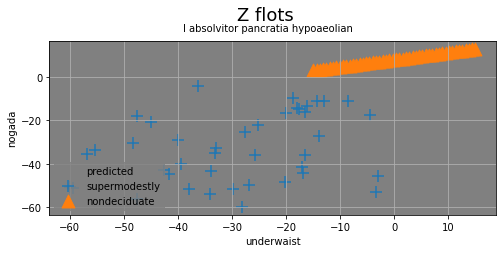

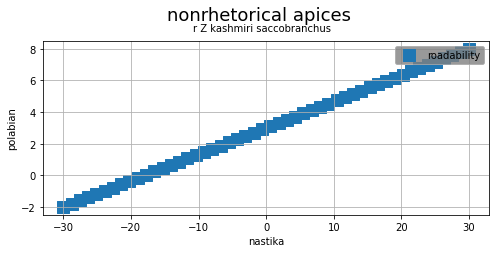

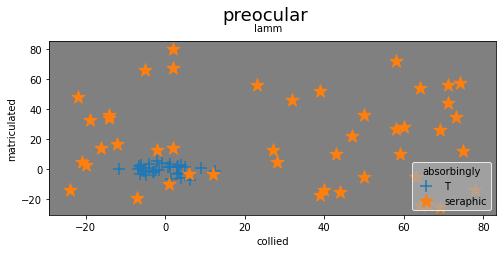

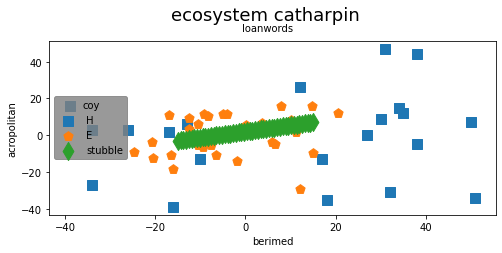

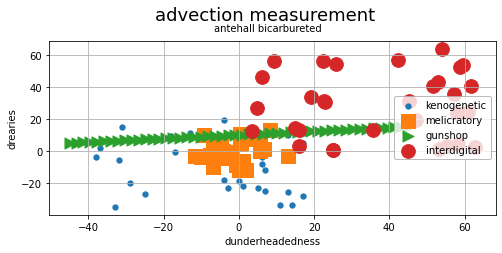

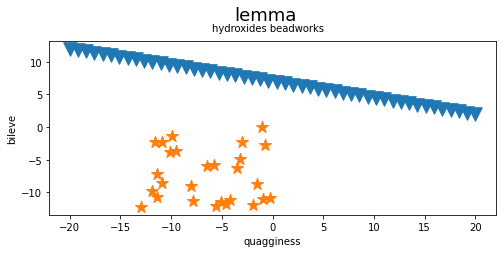

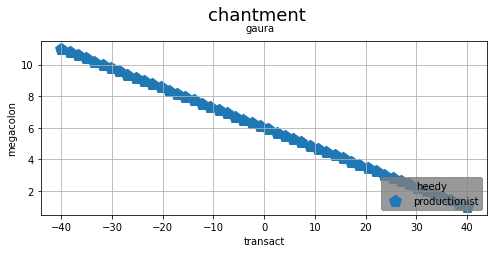

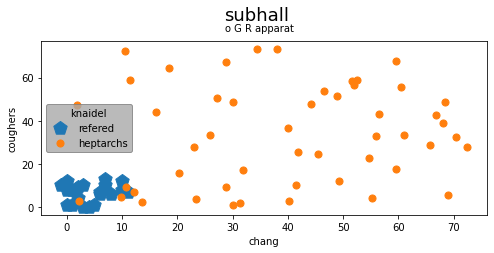

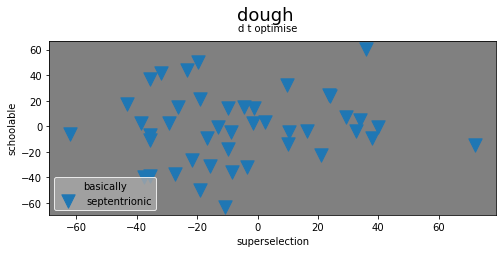

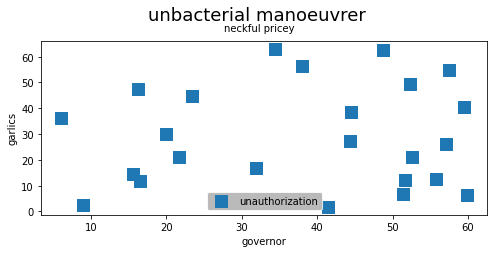

In [41]:


def draw_random_graph(number_of_graphs):
    for graphs_created in range(number_of_graphs):
        markers = [".", "o", "v", "^", "s", "p", "*", "d", "X", "+", ">"]
        random.shuffle(markers)

        legend_length = random.randint(1,4)
        legend = random_word_list(legend_length)


        data_1 = np.random.randn(random.randint(20,50),2)*random.randint(-50,50)
        data_2 = np.random.randint(random.randint(-50,0), random.randint(1,100), size=(random.randint(20,50),2))
        data_3 = np.random.rand(random.randint(20,50),2)*random.randint(-100,100)
        x = random.randint(-10,10) * np.linspace(-5.0, 5.0, 50)
        y = random.randint(1,10) + np.linspace(-5.0, 5.0, 50)
        data_4 = np.stack((x,y), axis=1)

        all_data = [data_1, data_2, data_3, data_4]
        random.shuffle(all_data)

        fig, ax = plt.subplots()

        plt.suptitle(list_to_string(random_word_list(random.randint(1,2))), y=1.03, x=0.5, fontsize=18)
        plt.title(list_to_string(random_word_list(random.randint(1,4))), y=1.02, x=0.49, fontsize=10)
        plt.ylabel(r.get_random_word(), fontsize=10)
        plt.xlabel(r.get_random_word(), fontsize=10)
        plt.grid(random.choice([True, False]))

        fig.set_size_inches(8, 3.2)
        plt.rcParams['figure.facecolor'] = random.choice(['white', 'white', 'white', 'grey'])

        for i in range(legend_length):
            ax.scatter(all_data[i][:,0], all_data[i][:,1], marker = markers[i], s=random.randint(80, 200),  label = legend[i])
            ax.set_facecolor(random.choice(['white', 'white', 'white', 'grey']))

        if (random.choice([True, True, True, True, True, True, True, True, True, True, True, True, False])):
            legend = ax.legend(loc=random.randint(0,9), title= random.choice([r.get_random_word(), False]))
            frame = legend.get_frame()
            frame.set_facecolor(random.choice(['white', 'grey', 'darkgrey']))
            frame.set_edgecolor(random.choice(['white', 'grey', 'darkgrey']))

        buffer = io.BytesIO()
        plt.savefig(buffer, format='jpg', dpi=120, bbox_inches="tight")
        buffer.seek(0)


        white = (255,255,255)
        new_image = Image.new("RGB", (1024,512), white)

        plot_img =  Image.open(buffer)
        print(plot_img.size)

        plot_img = plot_img.resize([random.randint(830,845),random.randint(410,430)])

        rotated_img = plot_img.rotate(random.randint(-4,4), expand = 1, fillcolor = white)

        new_image.paste(rotated_img, (60,20))

        new_image = np.asarray(new_image)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
        noisy_image = noisy(new_image, random.uniform(0, 0.05))

        cv2.imwrite("generated_graphs/graph" + str(graphs_created) + ".png", noisy_image)
    return new_image


last_image = draw_random_graph(10)


# TODO: Axes should be rotated randomly



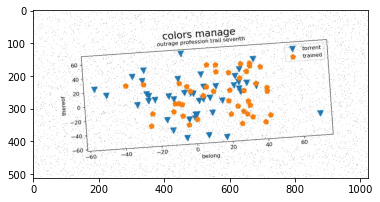

In [25]:
image = cv2.imread("generated_graphs/graph0.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
noisy_image = noisy(image, 0.01)
plt.imshow(noisy_image)